<a href="https://colab.research.google.com/github/Gbell26/GestureBot/blob/main/HandLandmark_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@InProceedings{Freihand2019,
  author    = {Christian Zimmermann, Duygu Ceylan, Jimei Yang, Bryan Russel, Max Argus and Thomas Brox},
  title     = {FreiHAND: A Dataset for Markerless Capture of Hand Pose and Shape from Single RGB Images},
  booktitle    = {IEEE International Conference on Computer Vision (ICCV)},
  year      = {2019},
  url          = {"https://lmb.informatik.uni-freiburg.de/projects/freihand/"}
}

https://keras.io/examples/vision/keypoint_detection/#data-collection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/rgb.zip" "/content/"
!cp "/content/drive/MyDrive/training_xyz.json" "/content/"
!cp "/content/drive/MyDrive/training_K.json" "/content/"


In [ ]:
!unzip -q /content/rgb.zip

In [ ]:
!ls /content/rgb

00000000.jpg  00018606.jpg  00037212.jpg  00055818.jpg	00074424.jpg  00093030.jpg  00111636.jpg
00000001.jpg  00018607.jpg  00037213.jpg  00055819.jpg	00074425.jpg  00093031.jpg  00111637.jpg
00000002.jpg  00018608.jpg  00037214.jpg  00055820.jpg	00074426.jpg  00093032.jpg  00111638.jpg
00000003.jpg  00018609.jpg  00037215.jpg  00055821.jpg	00074427.jpg  00093033.jpg  00111639.jpg
00000004.jpg  00018610.jpg  00037216.jpg  00055822.jpg	00074428.jpg  00093034.jpg  00111640.jpg
00000005.jpg  00018611.jpg  00037217.jpg  00055823.jpg	00074429.jpg  00093035.jpg  00111641.jpg
00000006.jpg  00018612.jpg  00037218.jpg  00055824.jpg	00074430.jpg  00093036.jpg  00111642.jpg
00000007.jpg  00018613.jpg  00037219.jpg  00055825.jpg	00074431.jpg  00093037.jpg  00111643.jpg
00000008.jpg  00018614.jpg  00037220.jpg  00055826.jpg	00074432.jpg  00093038.jpg  00111644.jpg
00000009.jpg  00018615.jpg  00037221.jpg  00055827.jpg	00074433.jpg  00093039.jpg  00111645.jpg
00000010.jpg  00018616.jpg  00037222.jpg

In [ ]:
import os
import json
import numpy as np

# Specify the paths to the image folder and joints JSON file
image_folder = '/content/rgb'
json_file_path = '/content/training_xyz.json'
k_file_path = '/content/training_K.json'

json_dict = {}

# Read the joints data from the JSON file
with open(json_file_path, 'r') as json_file:
    joints_data_list = json.load(json_file)

with open(k_file_path, 'r') as K_json_file:
    k_data_list = json.load(K_json_file)


filenames = os.listdir(image_folder)
sorted_filenames = sorted(filenames)
# Iterate over the image files in the folder
for index, image_file in enumerate(sorted_filenames):
    # Create the image path using the folder and file name
    jointsuv = {}
    img_path = os.path.join(image_folder, image_file)

    # Check if there is corresponding joints data for the current image
    if index < len(joints_data_list):
      #convert real world xyz to on screen uv coordinates
        xyz = np.array(joints_data_list[index])
        K = np.array(k_data_list[index])
        uv = np.matmul(K, xyz.T).T
        jointsuv = (uv[:, :2] / uv[:, -1:])
        # Add the image path and joints data to the dictionary
        json_dict[img_path] = {
            'img_path': img_path,
            'joints': jointsuv.tolist()
        }
    else:
        pass


In [ ]:
for key, value in list(json_dict.items())[:2]:
    print(key, value)

/content/rgb/00000000.jpg {'img_path': '/content/rgb/00000000.jpg', 'joints': [[131.4768940205016, 93.51373911989326], [115.25514183908237, 84.06097876167887], [105.88463862050533, 84.58545770996541], [94.50168750399692, 93.26688698971553], [78.98824452925486, 104.0501218235335], [101.82265661888262, 105.35759085038993], [92.17456645408994, 111.85755356515958], [84.41599324868237, 115.98129828141302], [78.9745503665487, 122.42578966938777], [97.16411939007406, 119.14486485616037], [86.62781285209444, 128.24283915772278], [78.4159814180122, 134.7244447920884], [73.84406513742165, 144.07088359327776], [95.55246012157508, 127.12309263529434], [85.40247158298146, 133.96378733581219], [76.19598544219458, 140.88579944831076], [69.26745710736786, 147.90199952067448], [93.36893067968045, 131.40327586029886], [84.57483726064683, 140.0324643606842], [76.85251383221191, 147.21305270034102], [72.10039976681325, 155.76313093744338]]}
/content/rgb/00000001.jpg {'img_path': '/content/rgb/00000001.jpg

In [ ]:
!pip install -q -U imgaug

In [ ]:
import keras

In [ ]:
print(keras.__version__)

2.15.0


In [ ]:
from keras import layers

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 200
NUM_KEYPOINTS = 21 * 2  # 21 keypoints each having x y coordinates

In [ ]:
# Utility for reading an image and for getting its annotations.
def get_hand(name):
    data = json_dict[name]
    img_data = plt.imread(data["img_path"])
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

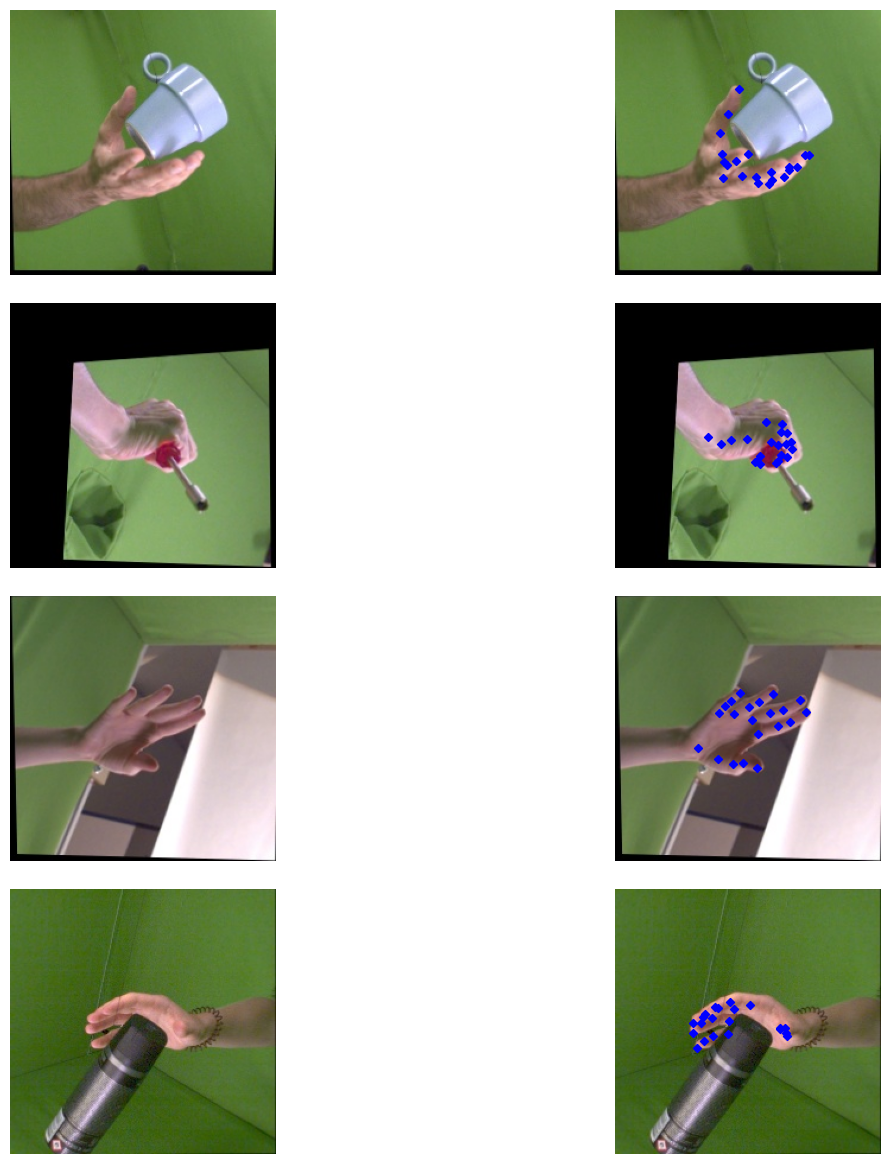

In [ ]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x],
                    [kp.y],
                    c='blue',
                    marker="x",
                    s=10,
                    linewidths=5,
                )
        else:
            current_keypoint = np.array(current_keypoint)
            for idx, (x, y) in enumerate(current_keypoint):
              ax_all.scatter([x], [y], c='blue', marker="x", s=10, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_hand(sample)
    image = data["img_data"]
    keypoint = data["joints"]
    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

In [ ]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_hand(key)
            current_keypoint = np.array(data["joints"])[:, :]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 21 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE
        #print(batch_keypoints)
        return (batch_images, batch_keypoints)

In [ ]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [ ]:
np.random.shuffle(samples)
# 15% validation 85% training
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

Total batches in training set: 432
Total batches in validation set: 76


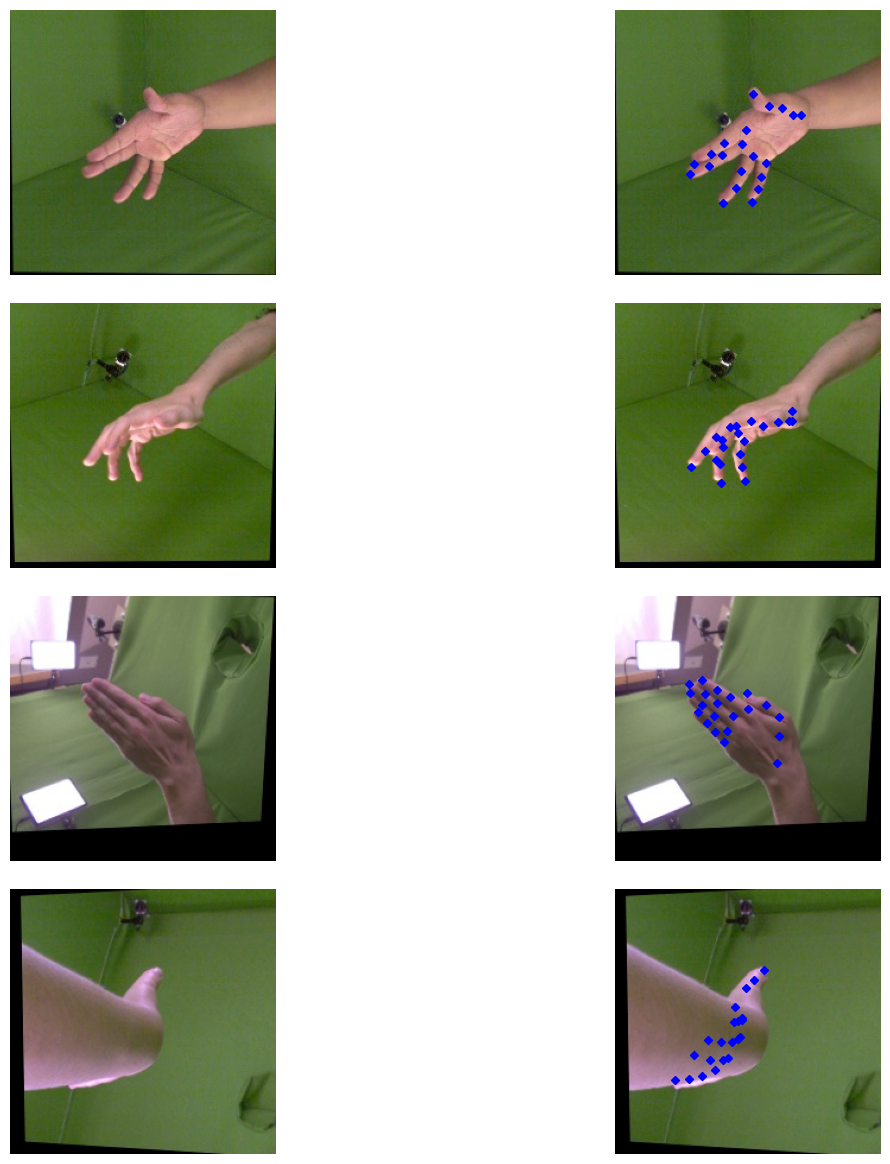

In [ ]:
train_dataset = KeyPointsDataset(
    train_keys, train_aug
)
validation_dataset = KeyPointsDataset(
    validation_keys, test_aug, train=False
)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))


sample_keypoints = sample_keypoints[:4].reshape(-1, 21, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

In [ ]:
#create transfer learning model
#load pretrained mobilenetv2 weights and change input & ouput

def get_model():

    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    backbone.trainable = True

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [ ]:
get_model().summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)     

In [ ]:
!nvidia-smi

Sat Mar  9 05:43:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              41W / 300W |    340MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#train model
model = get_model()


model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/200
432/432 [==============================] - 156s 297ms/step - loss: 0.0046 - accuracy: 0.2533 - val_loss: 0.0035 - val_accuracy: 0.4110
Epoch 2/200
432/432 [==============================] - 128s 296ms/step - loss: 0.0021 - accuracy: 0.4656 - val_loss: 0.0025 - val_accuracy: 0.4813
Epoch 3/200
432/432 [==============================] - 128s 295ms/step - loss: 0.0015 - accuracy: 0.5063 - val_loss: 0.0020 - val_accuracy: 0.5167
Epoch 4/200
432/432 [==============================] - 125s 289ms/step - loss: 0.0013 - accuracy: 0.5328 - val_loss: 0.0016 - val_accuracy: 0.5545
Epoch 5/200
432/432 [==============================] - 127s 295ms/step - loss: 0.0011 - accuracy: 0.5464 - val_loss: 0.0016 - val_accuracy: 0.5652
Epoch 6/200
432/432 [==============================] - 127s 295ms/step - loss: 0.0010 - accuracy: 0.5685 - val_loss: 0.0014 - val_accuracy: 0.5730
Epoch 7/200
432/432 [==============================] - 129s 298ms/step - loss: 9.3302e-04 - accuracy: 0.5779 - val_los

1/1 [==============================] - 1s 1s/step


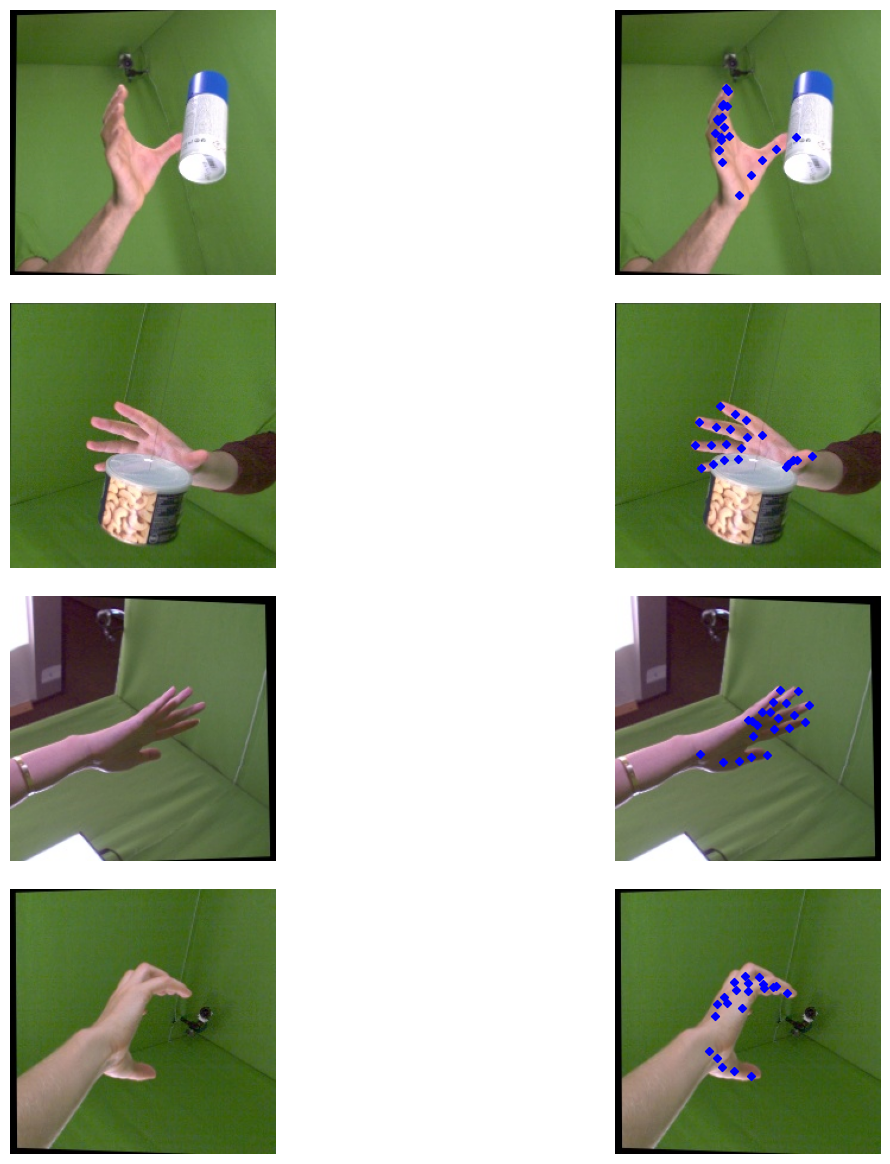

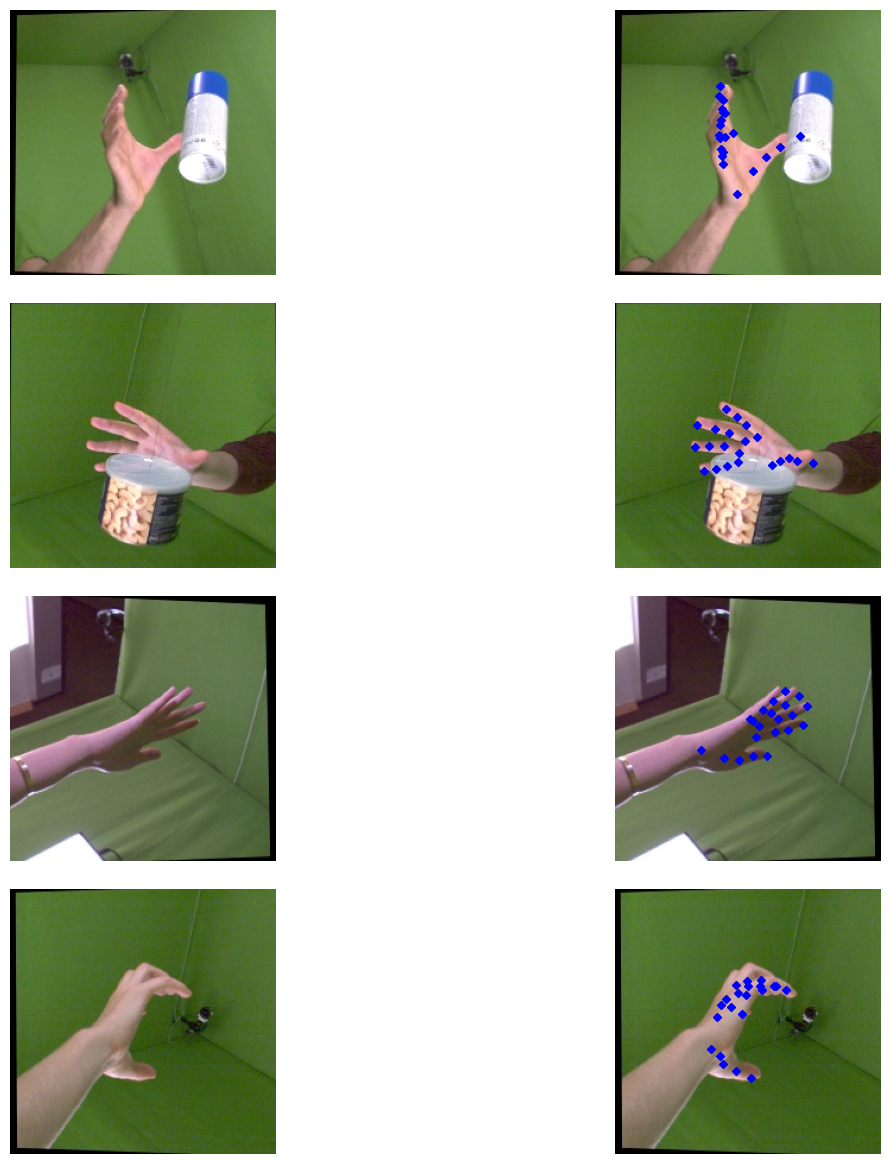

In [ ]:
#inference
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 21, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 21, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)

In [ ]:
import tensorflow as tf

In [ ]:
!mkdir Hand_landmarker

In [ ]:
#save the model
model.save(
    "/content/Hand_landmarker"
)

In [ ]:
#convert to tflite
try:
  converter = tf.lite.TFLiteConverter.from_saved_model('/content/Hand_landmarker')
  tflite_model = converter.convert()

  with open('/content/Hand_landmarker/keypoint_detector.tflite', 'wb') as f:
    f.write(tflite_model)
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
from google.colab import files

!zip -r '/content/Hand_landmarker.zip' '/content/Hand_landmarker'

  adding: content/Hand_landmarker/ (stored 0%)
  adding: content/Hand_landmarker/saved_model.pb (deflated 91%)
  adding: content/Hand_landmarker/assets/ (stored 0%)
  adding: content/Hand_landmarker/fingerprint.pb (stored 0%)
  adding: content/Hand_landmarker/keras_metadata.pb (deflated 96%)
  adding: content/Hand_landmarker/keypoint_detector.tflite (deflated 7%)
  adding: content/Hand_landmarker/variables/ (stored 0%)
  adding: content/Hand_landmarker/variables/variables.index (deflated 77%)
  adding: content/Hand_landmarker/variables/variables.data-00000-of-00001 (deflated 9%)


In [ ]:
#save the model to google drive to access easily for further training later

!cp "/content/Hand_landmarker.zip" "/content/drive/MyDrive/"

In [ ]:
#download the model
files.download("/content/Hand_landmarker.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>